# *Credit Card Fraud Detection - Task 2*

![logo](images/logo1.jpg)

In [63]:
import pandas as pd
import warnings
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

data = pd.read_csv("data/transactions.csv")
data = data.drop('trans_date_trans_time', axis = 1)
data = data.drop('trans_num', axis = 1)
data = data.dropna()
data = data.drop_duplicates()
data = pd.get_dummies(data)

data = pd.read_csv("data/data.csv")

## Modelação Preditiva

### Seleção de Técnicas de Modelação

Tomando em consideração os objetivos de mineração de dados, em particular o problema de classificação a tratar, optam-se pelas seguintes técnicas de modelação:
1. *K-Nearest Neighbors*
2. *Naive Bayes*
3. Árvore de Decisão
4. *Random Forest*
5. *Support Vector Machine*

### Geração do *Design* do Teste

In [64]:
all_inputs = data.drop('is_fraud', axis = 1)

all_labels = data['is_fraud']

(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(all_inputs, all_labels, test_size = 0.25, random_state = 13)

In [65]:
smote = SMOTE(random_state = 13)

(training_inputs_smoted, training_classes_smoted) = smote.fit_resample(training_inputs, training_classes)

print(Counter(training_classes_smoted))

Counter({0: 21041, 1: 21041})


In [66]:
scaler = StandardScaler()

training_inputs_scaled = scaler.fit_transform(training_inputs)

testing_inputs_scaled = scaler.transform(testing_inputs)

In [67]:
cross_validation = StratifiedKFold(n_splits = 10)

### Construção dos Modelos

#### Árvore de Decisão

In [78]:
decision_tree = DecisionTreeClassifier(random_state = 10)

decision_tree.fit(training_inputs_smoted, training_classes_smoted)

decision_tree_probs = decision_tree.predict_proba(testing_inputs)[:, 1]

decision_tree_auc = roc_auc_score(testing_classes, decision_tree_probs)
print('Decision Tree AUC: {:.2f}'.format(decision_tree_auc))

decision_tree_accuracy = decision_tree.score(testing_inputs, testing_classes)
print('Decision Tree Accuracy: {:.2f}%'.format(decision_tree_accuracy * 100))

Decision Tree AUC: 0.86
Decision Tree Accuracy: 98.07%


In [ ]:
decision_tree_probs = decision_tree.predict_proba(testing_inputs)[:, 1]

output_df = pd.DataFrame({
    'index': testing_inputs.index,
    'is_fraud': decision_tree_probs
})

output_df.to_csv('fraud_predictions.csv', index=False)

print("Predictions saved to 'fraud_predictions.csv'")


Predictions saved to 'fraud_predictions.csv'


In [22]:
decision_tree_parameter_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

decision_tree_grid_search = GridSearchCV(decision_tree, decision_tree_parameter_grid, cv = cross_validation, n_jobs = -1)

decision_tree_grid_search.fit(training_inputs_smoted, training_classes_smoted)

print('Decision Tree Best Score: {:.2f}%'.format(decision_tree_grid_search.best_score_ * 100))
print('Decision Tree Best Parameters:', decision_tree_grid_search.best_params_)

Decision Tree Best Score: 82.74%
Decision Tree Best Parameters: {'max_depth': 10, 'max_features': 8}


In [24]:
best_decision_tree_params = decision_tree_grid_search.best_params_
best_decision_tree = DecisionTreeClassifier(max_depth = best_decision_tree_params['max_depth'], max_features = best_decision_tree_params['max_features'], random_state = 13)
best_decision_tree.fit(training_inputs_smoted, training_classes_smoted)
best_decision_tree.score(testing_inputs, testing_classes)

0.908951048951049

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      7006
           1       0.03      0.11      0.05       144

    accuracy                           0.91      7150
   macro avg       0.51      0.52      0.50      7150
weighted avg       0.96      0.91      0.93      7150



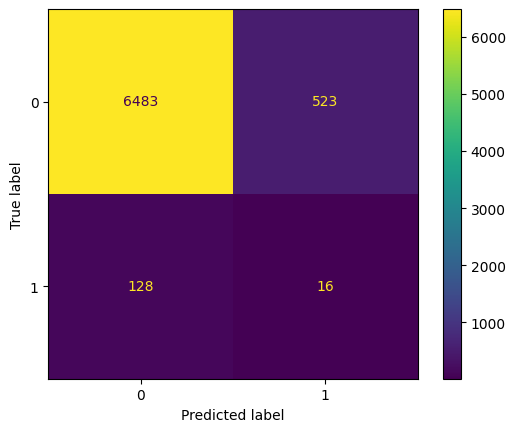

In [25]:
best_decision_tree_pred = best_decision_tree.predict(testing_inputs)

print(classification_report(testing_classes, best_decision_tree_pred))

best_decision_tree_confusion_matrix = confusion_matrix(testing_classes, best_decision_tree_pred)
ConfusionMatrixDisplay(best_decision_tree_confusion_matrix).plot()

#### Rede Neuronal

In [ ]:
neural_network = MLPClassifier(max_iter = 1000, random_state = 13)

neural_network.fit(training_inputs_scaled, training_classes)

neural_network_probs = neural_network.predict_proba(testing_inputs)[:, 1]

neural_network_auc = roc_auc_score(testing_classes, neural_network_probs)
print('Neural Network AUC: {:.2f}'.format(neural_network_auc))

neural_network_accuracy = neural_network.score(testing_inputs_scaled, testing_classes)
print('Neural Network Accuracy: {:.2f}%'.format(neural_network_accuracy * 100))

Neural Network AUC: 0.50
Neural Network Accuracy: 97.09%


In [14]:
neural_network_parameter_grid = {
    'hidden_layer_sizes': [(5, ), (6, ), (7, ), (5, 4), (5, 5), (6, 4), (6, 5), (6, 6)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
}

neural_network_grid_search = GridSearchCV(neural_network, neural_network_parameter_grid, n_jobs = -1)

neural_network_grid_search.fit(training_inputs_scaled, training_classes)

print('Neural Network Best Score: {:.2f}%'.format(neural_network_grid_search.best_score_ * 100))
print('Neural Network Best Parameters:', neural_network_grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
best_neural_network_params = neural_network_grid_search.best_params_
best_neural_network = MLPClassifier(hidden_layer_sizes = best_neural_network_params['hidden_layer_sizes'], activation = best_neural_network_params['activation'], solver = best_neural_network_params['solver'], random_state = 13)
best_neural_network.fit(training_inputs_scaled, training_classes)
best_neural_network.score(testing_inputs_scaled, testing_classes)

In [ ]:
best_neural_network_pred = best_neural_network.predict(testing_inputs_scaled)

print(classification_report(testing_classes, best_neural_network_pred))

best_neural_network_confusion_matrix = confusion_matrix(testing_classes, best_neural_network_pred)
ConfusionMatrixDisplay(best_neural_network_confusion_matrix).plot()

#### *K-Nearest Neighbors*

In [7]:
knn = KNeighborsClassifier()

knn.fit(training_inputs_scaled, training_classes)

knn_probs = knn.predict_proba(testing_inputs)[:, 1]

knn_auc = roc_auc_score(testing_classes, knn_probs)
print('K-Nearest Neighbors AUC: {:.2f}'.format(knn_auc))

knn_accuracy = knn.score(testing_inputs_scaled, testing_classes)
print('K-Nearest Neighbors Accuracy: {:.2f}%'.format(knn_accuracy * 100))

K-Nearest Neighbors AUC: 0.50
K-Nearest Neighbors Accuracy: 97.99%


In [16]:
knn_parameter_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_grid_search = GridSearchCV(knn, knn_parameter_grid, cv = cross_validation, n_jobs = -1)

knn_grid_search.fit(training_inputs_scaled, training_classes)

print('K-Nearest Neighbors Best Score: {:.2f}%'.format(knn_grid_search.best_score_ * 100))
print('K-Nearest Neighbors Best Parameters:', knn_grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
best_knn_params = knn_grid_search.best_params_
best_knn = KNeighborsClassifier(n_neighbors = best_knn_params['n_neighbors'], weights = best_knn_params['weights'], metric = best_knn_params['metric'])
best_knn.fit(training_inputs_scaled, training_classes)
best_knn.score(testing_inputs_scaled, testing_classes)

In [ ]:
best_knn_pred = best_knn.predict(testing_inputs_scaled)

print(classification_report(testing_classes, best_knn_pred))

best_knn_confusion_matrix = confusion_matrix(testing_classes, best_knn_pred)
ConfusionMatrixDisplay(best_knn_confusion_matrix).plot()

#### *Support Vector Machine*

In [10]:
svm = SVC(random_state = 13)

svm.fit(training_inputs_scaled, training_classes)

svm_probs = svm.predict_proba(testing_inputs)[:, 1]

svm_auc = roc_auc_score(testing_classes, svm_probs)
print('Support vector Machine AUC: {:.2f}'.format(svm_auc))

svm_accuracy = svm.score(testing_inputs_scaled, testing_classes)
print('Support vector Machine Accuracy: {:.2f}%'.format(svm_accuracy * 100))

AttributeError: This 'SVC' has no attribute 'predict_proba'

In [ ]:
svm_parameter_grid = {
    'C': [0.9, 1.0, 1.1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svm_grid_search = GridSearchCV(svm, svm_parameter_grid, cv = cross_validation, n_jobs = -1)

svm_grid_search.fit(training_inputs_scaled, training_classes)

print("Support Vector Machine Best Score: {:.2f}%".format(svm_grid_search.best_score_ * 100))
print("Support Vector Machine Best Parameters:", svm_grid_search.best_params_)

In [ ]:
best_svm_params = svm_grid_search.best_params_
best_svm = SVC(C = best_svm_params['C'], kernel = best_svm_params['kernel'], gamma = best_svm_params['gamma'], random_state = 13)
best_svm.fit(training_inputs_scaled, training_classes)
best_svm.score(testing_inputs_scaled, testing_classes)

In [ ]:
best_svm_pred = best_svm.predict(testing_inputs_scaled)

print(classification_report(testing_classes, best_svm_pred))

best_svm_confusion_matrix = confusion_matrix(testing_classes, best_svm_pred)
ConfusionMatrixDisplay(best_svm_confusion_matrix).plot()

#### *Random Forest*

In [39]:
random_forest = RandomForestClassifier(random_state = 10)

random_forest.fit(training_inputs, training_classes)

random_forest_probs = random_forest.predict_proba(testing_inputs)[:, 1]

random_forest_auc = roc_auc_score(testing_classes, random_forest_probs)
print('Random Forest AUC: {:.2f}'.format(random_forest_auc))

random_forest_accuracy = random_forest.score(testing_inputs, testing_classes)
print('Random Forest Accuracy: {:.2f}%'.format(random_forest_accuracy * 100))

Random Forest AUC: 0.50
Random Forest Accuracy: 97.99%


In [ ]:
random_forest_parameter_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [30, 40],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['log2', 'sqrt']
}

random_forest_grid_search = GridSearchCV(random_forest, random_forest_parameter_grid, cv = cross_validation, n_jobs = -1)

random_forest_grid_search.fit(training_inputs, training_classes)

print('Random Forest Best Score: {:.2f}%'.format(random_forest_grid_search.best_score_ * 100))
print('Random Forest Best Parameters:', random_forest_grid_search.best_params_)

In [ ]:
best_random_forest_params = random_forest_grid_search.best_params_
best_random_forest = RandomForestClassifier(n_estimators = best_random_forest_params['n_estimators'], max_depth = best_random_forest_params['max_depth'], min_samples_split = best_random_forest_params['min_samples_split'], min_samples_leaf = best_random_forest_params['min_samples_leaf'], max_features = best_random_forest_params['max_features'])
best_random_forest.fit(training_inputs, training_classes)
best_random_forest.score(testing_inputs, testing_classes)

In [ ]:
best_random_forest_pred = best_random_forest.predict(testing_inputs)

print(classification_report(testing_classes, best_random_forest_pred))

best_random_forest_confusion_matrix = confusion_matrix(testing_classes, best_random_forest_pred)
ConfusionMatrixDisplay(best_random_forest_confusion_matrix).plot()

### Avaliação dos Modelos

## Avaliação

### Avaliação dos Resultados

In [ ]:
models = [best_decision_tree, best_neural_network, best_knn, best_svm, best_random_forest]
labels = ['Decision Tree', 'Neural Network', 'K-Nearest Neighbors', 'Support Vector Machine', 'Random Forest']
accuracies = []

for model in models:
    pipeline = make_pipeline(scaler, model)
    accuracy = cross_val_score(pipeline, all_inputs, all_labels, cv = cross_validation)
    accuracies.append(accuracy)

plt.figure(figsize = (20, 10))
plt.boxplot(accuracies, labels = labels)
plt.title('Accuracy')

### Revisão do Processo

### Determinação dos Próximos Passos

## Produção